# Predicting Baseball Game Outcomes

### Load in packages

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import collections as c
import datetime
from __future__ import division
import time
import itertools
from time import sleep
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline

### Cleaning Data

In [2]:
# Load in data from CSV
bat = pd.read_csv('batter_table.csv')
pitch = pd.read_csv('pitcher_table.csv')
box = pd.read_csv('boxscore_table.csv')

# Convert boxscore lineups to lists by splitting on ':'
def lineup_list(x):
    return x.split(':')     
box['home_lineup'] = box.home_lineup.apply(lineup_list) 
box['away_lineup'] = box.away_lineup.apply(lineup_list) 
# Only Take Regular Season Games to pull data on
box = box[box.game_type_des == 'Regular Season']

/Users/thomasdobbs/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
# OVERVIEW OF TABLES SCRAPED FROM MLB.COM
print '''
BATTER OVERVIEW
'''
print bat.info()
print bat[['at_bats','hits','runs','strike_out','double','triple','home_run','walk','rbi','stolen_bases']].describe()
#print bat.head(5)
print '''

PITCHER OVERVIEW
'''
print pitch.info()
print pitch[['p_runs','p_earned_runs','outs','p_so','p_era']].describe()
#print pitch.head(5)
print '''

BOXSCORE OVERVIEW
'''
print box.info()
print box[['away_team_runs','home_team_runs','home_win']].describe()
#print box.head(5)
#'''


BATTER OVERVIEW

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919775 entries, 0 to 919774
Data columns (total 27 columns):
game_id              919775 non-null object
date                 919775 non-null object
game_pk              919775 non-null int64
away_fname           919775 non-null object
home_fname           919775 non-null object
away_id              919775 non-null int64
home_id              919775 non-null int64
team_flag            919775 non-null object
total_runs           919775 non-null int64
total_earned_runs    919775 non-null int64
batter_id            919775 non-null int64
batter_name          919775 non-null object
position             919765 non-null object
at_bats              919775 non-null int64
hits                 919775 non-null int64
runs                 919775 non-null int64
strike_out           919775 non-null int64
walk                 919775 non-null int64
home_run             919775 non-null int64
double               919775 non-null int64
trip

### Data Munging

In [36]:
# REVEAL INDIVIDUAL PLAYER PROFILE w/in LINEUP
def individual_batter_example(boxscore,atbats):
    n=0
    newbat=bat.set_index('date')
    for lineup,date in zip(boxscore.home_lineup,boxscore.date):                
        prior_bat = newbat[:'2015-07-08']
        for batter in lineup:
            if n > 2:
                break
            else:
                print date,batter
                n+=1     
                for games in range(10,101,1): 
                    recent_games=prior_bat[prior_bat.batter_id == int(batter)].tail(games)
                    recent_games.reset_index(level=0, inplace=True)
                    recent_games = recent_games[recent_games.date != '2015-07-08']
                    if recent_games.at_bats.count() == 0:
                        pass
                    elif recent_games.at_bats.sum() >= atbats or games == 100:
                        print 'Name:',recent_games.batter_name.unique()
                        print 'Games:',recent_games.at_bats.count()
                        print 'At_Bats:', recent_games.at_bats.sum()
                        print round(recent_games.runs.sum()/recent_games.at_bats.sum(),3), 'runs/at_bat'
                        print round(recent_games.runs.sum()/recent_games.at_bats.count(),3), 'runs/game'
                        print recent_games.runs.sum(), 'total runs'
                        print round(recent_games.rbi.sum()/recent_games.at_bats.sum(),3), 'rbi/at_bat'
                        print round(recent_games.rbi.sum()/recent_games.at_bats.count(),3), 'rbi/game'                            
                        print recent_games.rbi.sum(), 'total rbis'                        
                        print''
                        break
                    else:
                        pass
                
individual_batter_example(box,200)

2015-04-05 451594
Name: ['Dexter Fowler']
Games: 54
At_Bats: 200
0.175 runs/at_bat
0.648 runs/game
35 total runs
0.09 rbi/at_bat
0.333 rbi/game
18 total rbis

2015-04-05 624585
Name: ['Jorge Soler']
Games: 54
At_Bats: 203
0.108 runs/at_bat
0.407 runs/game
22 total runs
0.099 rbi/at_bat
0.37 rbi/game
20 total rbis

2015-04-05 519203
Name: ['Anthony Rizzo']
Games: 55
At_Bats: 200
0.115 runs/at_bat
0.418 runs/game
23 total runs
0.155 rbi/at_bat
0.564 rbi/game
31 total rbis



In [47]:
# OVERVIEW OF CREATING NEW PERFORMANCE COLUMNS
def perf_col_overview(boxscore,at_bats):
    newbat=bat.set_index('date')
    n=0
    for lineup,date,team in zip(boxscore.home_lineup,boxscore.date,boxscore.home_team_code):                
        lu_run = 0
        lu_rbi = 0
        prior_bat = newbat[:date]     
        for batter in lineup:        
            for games in range(10,101,1): 
                recent_games=prior_bat[prior_bat.batter_id == int(batter)].tail(games)
                recent_games.reset_index(level=0, inplace=True)
                recent_games = recent_games[recent_games.date != date]
                if recent_games.at_bats.count() == 0:
                    pass
                elif recent_games.at_bats.sum() >= at_bats or games == 100:                        
                    lu_run+=recent_games.runs.sum()/recent_games.at_bats.count()
                    lu_rbi+=recent_games.rbi.sum()/recent_games.at_bats.count()
                    break
        if n > 164:
            break
        elif n > 150:
            print date, team, round(lu_run,4), 'runs',round(lu_rbi,4), 'rbis'
            n+=1
        else:
            pass
            n+=1
        
perf_col_overview(box,100)        

2015-04-17 was 4.425 runs 3.7 rbis
2015-04-17 chn 4.125 runs 3.5417 rbis
2015-04-17 sea 3.4837 runs 3.0508 rbis
2015-04-18 hou 2.0508 runs 2.4889 rbis
2015-04-18 sfn 2.4394 runs 1.9318 rbis
2015-04-18 tor 5.3465 runs 4.6237 rbis
2015-04-18 bos 5.5417 runs 5.4056 rbis
2015-04-18 det 3.9786 runs 4.3607 rbis
2015-04-18 sln 2.9167 runs 3.4861 rbis
2015-04-18 min 2.3778 runs 2.325 rbis
2015-04-18 lan 4.8198 runs 3.9762 rbis
2015-04-18 nyn 4.4606 runs 3.8556 rbis
2015-04-18 pit 3.1639 runs 4.125 rbis
2015-04-18 tba 3.4811 runs 3.9104 rbis


In [100]:
# BATTING PERFORMANCE COLUMN
def batter_performance(boxscore):
    newbat=bat.set_index('date')  
    milestone=['5/25/06','9/25/06','5/25/07','9/25/07','5/25/08','9/25/08','5/25/09','9/25/09','5/25/10','9/25/10',
               '5/25/11','9/25/11','5/25/12','9/25/12','5/25/13','9/25/13','5/25/14','9/25/14','5/25/15','9/25/15']
    home_run = 0
    home_rbi = 0
    home_hits = 0
    away_run = 0
    away_rbi = 0
    away_hits = 0
    prior_bat = newbat[:boxscore.date]                             
    for batter in boxscore.home_lineup:        
        for games in range(50,72,1): 
            recent_games=prior_bat[prior_bat.batter_id == int(batter)].tail(games)
            recent_games.reset_index(level=0, inplace=True)
            recent_games = recent_games[recent_games.date != boxscore.date]
            if recent_games.at_bats.sum() < 51 and games == 70:
                home_run+=bat.runs.sum()/bat.at_bats.count()
                home_rbi+=bat.rbi.sum()/bat.at_bats.count()
                home_hits+=bat.hits.sum()/bat.at_bats.count()
                break
            elif recent_games.at_bats.sum() >= 200 or games == 70:                        
                home_run+=recent_games.runs.sum()/recent_games.at_bats.count()
                home_rbi+=recent_games.rbi.sum()/recent_games.at_bats.count()
                home_hits+=recent_games.hits.sum()/recent_games.at_bats.count()
                break
    for batter in boxscore.away_lineup:        
        for games in range(50,72,1): 
            recent_games=prior_bat[prior_bat.batter_id == int(batter)].tail(games)
            recent_games.reset_index(level=0, inplace=True)
            recent_games = recent_games[recent_games.date != boxscore.date]
            if recent_games.at_bats.sum() < 51 and games == 70:
                away_run+=bat.runs.sum()/bat.at_bats.count()
                away_rbi+=bat.rbi.sum()/bat.at_bats.count()
                away_hits+=bat.hits.sum()/bat.at_bats.count()
                break
            elif recent_games.at_bats.sum() >= 200 or games == 70:                        
                away_run+=recent_games.runs.sum()/recent_games.at_bats.count()
                away_rbi+=recent_games.rbi.sum()/recent_games.at_bats.count()
                away_hits+=recent_games.hits.sum()/recent_games.at_bats.count()
                break
                
    if boxscore.date in milestone:
        print 'up to', boxscore.date, ', done at:', datetime.datetime.now().time()

    #print boxscore.date,boxscore.game_pk,'home_lineup:',boxscore.home_fname,round(home_run,2),'runs',round(home_rbi,2),'rbis',round(home_hits,2),'avg' 
    #print boxscore.date,boxscore.game_pk,'away_lineup:',boxscore.away_fname,round(away_run,2),'runs',round(away_rbi,2),'rbis',round(away_hits,2),'avg' 
    return round(home_run,2),round(home_rbi,2),round(home_hits,2),round(away_run,2),round(away_rbi,2),round(away_hits,2)

# PITCHER PERFORMANCE COLUMN
def pitcher_performance(boxscore):
    newpitch=pitch.set_index('date')
    milestone=['5/25/06','9/25/06','5/25/07','9/25/07','5/25/08','9/25/08','5/25/09','9/25/09','5/25/10','9/25/10',
               '5/25/11','9/25/11','5/25/12','9/25/12','5/25/13','9/25/13','5/25/14','9/25/14','5/25/15','9/25/15']
    home_er_outs = 0
    home_runs_outs = 0
    home_outs = 0
    away_er_outs = 0
    away_runs_outs = 0
    away_outs = 0
    prior_pitch = newpitch[:boxscore.date]                             
    for games in range(10,32,1): 
        recent_games = prior_pitch[prior_pitch.pitcher_id == int(boxscore.home_pitcher)].tail(games)
        recent_games.reset_index(level=0, inplace=True)
        recent_games = recent_games[recent_games.date != boxscore.date]
        h_pitcher = recent_games.pitcher_name.unique()      
        if recent_games.outs.count() < 6 or recent_games.outs.sum() <= 100:
            home_runs_outs+=pitch.p_runs.sum()/pitch.outs.sum()
            home_er_outs+=pitch.p_earned_runs.sum()/pitch.outs.sum()
            break
        elif recent_games.outs.sum() >= 301 or games == 30:            
            home_runs_outs+=recent_games.p_runs.sum()/recent_games.outs.sum()
            home_er_outs+=recent_games.p_earned_runs.sum()/recent_games.outs.sum()
            home_outs+=recent_games.outs.sum()
            break
    for games in range(10,32,1): 
        recent_games=prior_pitch[prior_pitch.pitcher_id == int(boxscore.away_pitcher)].tail(games)
        recent_games.reset_index(level=0, inplace=True)
        recent_games = recent_games[recent_games.date != boxscore.date]
        a_pitcher = recent_games.pitcher_name.unique()
        if recent_games.outs.count() < 6 or recent_games.outs.sum() <= 100:
            away_runs_outs+=pitch.p_runs.sum()/pitch.outs.sum()
            away_er_outs+=pitch.p_earned_runs.sum()/pitch.outs.sum()
            break
        elif recent_games.outs.sum() >= 301 or games == 30:            
            away_runs_outs+=recent_games.p_runs.sum()/recent_games.outs.sum()
            away_er_outs+=recent_games.p_earned_runs.sum()/recent_games.outs.sum()
            away_outs+=recent_games.outs.sum()
            break
    
    if boxscore.date in milestone:
        print 'up to', boxscore.date, 'complete'
        print datetime.datetime.now().time()
    
    #print boxscore.date,boxscore.game_pk,boxscore.home_fname,'home_pitcher:',h_pitcher,boxscore.home_pitcher,'outs:',home_outs,round(home_runs_outs*27,2),'runs/game',round(home_er_outs*27,2),'er/game'
    #print boxscore.date,boxscore.game_pk,boxscore.away_fname,'away_pitcher:',a_pitcher,boxscore.away_pitcher,'outs:',away_outs,round(away_runs_outs*27,2),'runs/game',round(away_er_outs*27,2),'er/game'
    return round(home_runs_outs*27,2),round(home_er_outs*27,2),round(away_runs_outs*27,2),round(away_er_outs*27,2)

# TEAM PERFORMANCE COLUMN
def team_performance(boxscore):
    newbox=box.set_index('date')
    milestone=['5/25/06','9/25/06','5/25/07','9/25/07','5/25/08','9/25/08','5/25/09','9/25/09','5/25/10','9/25/10',
               '5/25/11','9/25/11','5/25/12','9/25/12','5/25/13','9/25/13','5/25/14','9/25/14','5/25/15','9/25/15']
    home_win_prob = 0
    home_avg_runs = 0
    away_win_prob = 0
    away_avg_runs = 0
    prior_box = newbox[:boxscore.date]                             
    for games in range(10,52,1): 
        recent_games = prior_box[prior_box.home_id == int(boxscore.home_id)].tail(games)        
        recent_games.reset_index(level=0, inplace=True)
        recent_games = recent_games[recent_games.date != boxscore.date]
        h_games=games
        if recent_games.home_wins.count() <= 30 and games == 50:
            h_games=0
            home_win_prob+=(box[box.winning_team=='home'].winning_team.count())/box.winning_team.count()
            home_avg_runs+=box.home_team_runs.sum()/box.home_wins.count()            
            break
        elif games >= 51:
            h_games=recent_games.winning_team.count()
            home_win_prob+=(recent_games[recent_games.winning_team=='home'].winning_team.count())/recent_games.winning_team.count()
            home_avg_runs+=recent_games.home_team_runs.sum()/recent_games.home_wins.count()
            break
    for games in range(10,52,1):         
        recent_games = prior_box[prior_box.away_id == int(boxscore.away_id)].tail(games)        
        recent_games.reset_index(level=0, inplace=True)
        recent_games = recent_games[recent_games.date != boxscore.date]        
        if recent_games.away_wins.count() <= 30 and games == 50:
            a_games=0
            away_win_prob+=(box[box.winning_team=='away'].winning_team.count())/box.winning_team.count()
            away_avg_runs+=box.away_team_runs.sum()/box.winning_team.count()
            break
        elif games >= 51:
            a_games=recent_games.winning_team.count()
            away_win_prob+=(recent_games[recent_games.winning_team=='away'].winning_team.count())/recent_games.winning_team.count()
            away_avg_runs+=recent_games.away_team_runs.sum()/recent_games.winning_team.count()
            break
    if boxscore.date in milestone:
        print 'up to', boxscore.date, 'complete'
        print datetime.datetime.now().time()
            
    #print boxscore.date,boxscore.game_pk,'home_team:',boxscore.home_fname,'games:',h_games,round(home_win_prob,3),'win_prob',round(home_avg_runs,2),'avg_runs'
    #print boxscore.date,boxscore.game_pk,'away_team:',boxscore.away_fname,'games:',a_games,round(away_win_prob,3),'win_prob',round(away_avg_runs,2),'avg_runs'
    return round(home_win_prob,3),round(home_avg_runs,2),round(away_win_prob,3),round(away_avg_runs,2)

In [48]:
# APPLIES pitcher_performance FUNCTION TO CREATE PITCHER_PERFORMANCE COLUMNS
box["home_runs_outs"],box["home_er_outs"],box["away_runs_outs"],box["away_er_outs"]\
= zip(*box.apply(pitcher_performance,axis=1))

up to 5/25/06 complete
up to 5/25/06 complete
up to 5/25/06 complete
up to 5/25/06 complete
up to 5/25/06 complete
up to 5/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 9/25/06 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 5/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/07 complete
up to 9/25/

In [101]:
# APPLIES batter_performance FUNCTION TO CREATE BATTER_PERFORMANCE COLUMNS
box["home_run_pred"],box["home_rbi_pred"],box["home_hits_pred"],\
box["away_run_pred"],box["away_rbi_pred"],box["away_hits_pred"] \
= zip(*box.apply(batter_performance,axis=1))

up to 5/25/06 , done at: 19:19:32.377102
up to 5/25/06 , done at: 19:19:33.315120
up to 5/25/06 , done at: 19:19:34.112239
up to 5/25/06 , done at: 19:19:34.814011
up to 5/25/06 , done at: 19:19:35.629719
up to 5/25/06 , done at: 19:19:36.482903
up to 9/25/06 , done at: 19:45:33.387363
up to 9/25/06 , done at: 19:45:34.287984
up to 9/25/06 , done at: 19:45:34.986938
up to 9/25/06 , done at: 19:45:36.024783
up to 9/25/06 , done at: 19:45:36.989437
up to 9/25/06 , done at: 19:45:37.733241
up to 9/25/06 , done at: 19:45:38.599802
up to 9/25/06 , done at: 19:45:39.166590
up to 9/25/06 , done at: 19:45:40.100648
up to 9/25/06 , done at: 19:45:40.662384
up to 9/25/06 , done at: 19:45:41.532585
up to 5/25/07 , done at: 20:00:17.057360
up to 5/25/07 , done at: 20:00:18.200780
up to 5/25/07 , done at: 20:00:19.191209
up to 5/25/07 , done at: 20:00:25.931239
up to 5/25/07 , done at: 20:00:26.939989
up to 5/25/07 , done at: 20:00:28.132213
up to 5/25/07 , done at: 20:00:29.223673
up to 5/25/07 , 

In [55]:
# APPLIES team_performance FUNCTION TO CREATE TEAM_PERFORMANCE COLUMNS
box["home_win_prob"],box["home_avg_runs"],\
box["away_win_prob"],box["away_avg_runs"]\
= zip(*box.apply(team_performance,axis=1))

up to 5/25/06 complete
15:13:13.730151
up to 5/25/06 complete
15:13:13.879368
up to 5/25/06 complete
15:13:14.041491
up to 5/25/06 complete
15:13:14.199803
up to 5/25/06 complete
15:13:14.353620
up to 5/25/06 complete
15:13:14.507413
up to 9/25/06 complete
15:17:20.671438
up to 9/25/06 complete
15:17:20.830464
up to 9/25/06 complete
15:17:20.986621
up to 9/25/06 complete
15:17:21.138628
up to 9/25/06 complete
15:17:21.290067
up to 9/25/06 complete
15:17:21.442521
up to 9/25/06 complete
15:17:21.598397
up to 9/25/06 complete
15:17:21.753418
up to 9/25/06 complete
15:17:21.905166
up to 9/25/06 complete
15:17:22.055816
up to 9/25/06 complete
15:17:22.209384
up to 5/25/07 complete
15:19:21.866213
up to 5/25/07 complete
15:19:22.030292
up to 5/25/07 complete
15:19:22.186715
up to 5/25/07 complete
15:19:22.344439
up to 5/25/07 complete
15:19:22.498405
up to 5/25/07 complete
15:19:22.653858
up to 5/25/07 complete
15:19:22.810277
up to 5/25/07 complete
15:19:22.963783
up to 5/25/07 complete
15

### Save munged dataframe and format data for predictions

In [102]:
box.head()

,game_id,date,game_pk,game_type_des,away_fname,home_fname,away_id,home_id,home_pitcher,away_pitcher,...,home_win_prob,home_avg_runs,away_win_prob,away_avg_runs,home_run_pred,home_rbi_pred,home_hits_pred,away_run_pred,away_rbi_pred,away_hits_pred
469,2006/04/02/clemlb-chamlb-1,4/2/06,39939,Regular Season,Cleveland Indians,Chicago White Sox,114,145,279824,282332,...,0.54,4.48,0.453,4.32,3.55,3.85,7.54,4.06,3.96,7.21
472,2006/04/03/anamlb-seamlb-1,4/3/06,39951,Regular Season,Los Angeles Angels,Seattle Mariners,108,136,119469,112526,...,0.54,4.48,0.453,4.32,3.11,2.93,6.84,3.77,3.24,6.77
473,2006/04/03/arimlb-colmlb-1,4/3/06,39942,Regular Season,Arizona Diamondbacks,Colorado Rockies,109,115,407298,425630,...,0.54,4.48,0.453,4.32,4.03,3.58,7.42,3.46,4.00,6.94
474,2006/04/03/atlmlb-lanmlb-1,4/3/06,39945,Regular Season,Atlanta Braves,Los Angeles Dodgers,144,119,117955,218596,...,0.54,4.48,0.453,4.32,2.82,2.63,5.28,3.02,2.66,5.49
475,2006/04/03/bosmlb-texmlb-1,4/3/06,39952,Regular Season,Boston Red Sox,Texas Rangers,111,140,119154,121811,...,0.54,4.48,0.453,4.32,3.32,3.64,6.16,2.85,2.59,6.30


In [103]:
newbox=box.set_index('date')
newbox.head()
prior_box = newbox['4/1/07':]
prior_box.reset_index(level=0, inplace=True)
box_final=prior_box

In [104]:
# SAVE NEW BOXSCORE TO CSV
box_final.to_csv('box_final.csv', index=False)

In [45]:
# Save file
box_final = pd.read_csv('box_final.csv')

In [46]:
# Simpler view of dataframe
box_final = box_final[['home_win','home_win_prob','home_avg_runs','away_win_prob', 
                       'away_avg_runs','home_runs_outs','away_runs_outs','home_run_pred',
                       'home_rbi_pred','home_hits_pred','away_run_pred','away_rbi_pred','away_hits_pred']]

In [47]:
# Creates win prob differential
box_final['win_prob_diff'] = box_final['home_win_prob'] - box_final['away_win_prob']
box_final = box_final.drop(['away_win_prob'], axis=1)

# Creates interaction features for hits & rbi predictions
box_final['away_rbi*hits'] = box_final['away_rbi_pred'] * box_final['away_hits_pred']
box_final['home_rbi*hits'] = box_final['home_rbi_pred'] * box_final['home_hits_pred']
box_final = box_final.drop(['away_rbi_pred', 'home_rbi_pred', 'away_hits_pred', 'home_hits_pred'], axis=1)

#Creates interaction between lineup performance and team performance
box_final['away_avg_runs(team_vs_lineup)'] = (box_final['away_avg_runs'] * box_final['away_run_pred']) / 2.
box_final['home_avg_runs(team_vs_lineup)'] = (box_final['home_avg_runs'] * box_final['home_run_pred']) / 2.
box_final = box_final.drop(['away_avg_runs', 'home_avg_runs', 'away_run_pred', 'home_run_pred'], axis=1)

# Combines (Lineup avg. runs, Team avg. runs, lineup avg. hits and lineup avg. rbis) into an output column
box_final['away_output'] = (box_final['away_avg_runs(team_vs_lineup)'] * box_final['away_rbi*hits']) / 2.
box_final['home_output'] = (box_final['home_avg_runs(team_vs_lineup)'] * box_final['home_rbi*hits']) / 2.
box_final['output_diff'] = box_final['home_output'] - box_final['away_output']
box_final = box_final.drop(['away_avg_runs(team_vs_lineup)', 'home_avg_runs(team_vs_lineup)',\
                            'home_rbi*hits', 'away_rbi*hits'], axis=1)

box_final.head()

,home_win,home_win_prob,home_runs_outs,away_runs_outs,win_prob_diff,away_output,home_output,output_diff
0,0,0.54,3.16,4.13,0.02,155.794728,67.438201,-88.356527
1,0,0.44,4.87,4.13,0.02,142.808211,305.090302,162.282091
2,0,0.46,3.94,3.71,0.04,126.785736,200.822833,74.037097
3,1,0.64,2.35,3.58,0.18,105.738797,155.708421,49.969624
4,1,0.54,6.47,3.91,0.18,135.361989,184.683128,49.321139


In [48]:
corr_matrix = box_final.corr()
corr_cols = corr_matrix.columns
corr_array = corr_matrix.values
corr_cols
corr_array[:,:2]
corr_matrix

,home_win,home_win_prob,home_runs_outs,away_runs_outs,win_prob_diff,away_output,home_output,output_diff
home_win,1.000000,0.030322,-0.035808,0.034931,0.041734,-0.021715,0.014473,0.029071
home_win_prob,0.030322,1.000000,-0.172766,0.020504,0.728243,-0.007177,0.190397,0.170302
home_runs_outs,-0.035808,-0.172766,1.000000,0.041042,-0.118580,0.069860,0.062405,0.000813
away_runs_outs,0.034931,0.020504,0.041042,1.000000,0.127984,0.036756,0.072394,0.034677
win_prob_diff,0.041734,0.728243,-0.118580,0.127984,1.000000,-0.180124,0.135288,0.254329
away_output,-0.021715,-0.007177,0.069860,0.036756,-0.180124,1.000000,0.250004,-0.545283
home_output,0.014473,0.190397,0.062405,0.072394,0.135288,0.250004,1.000000,0.675311
output_diff,0.029071,0.170302,0.000813,0.034677,0.254329,-0.545283,0.675311,1.000000


Index([u'home_win', u'home_win_prob', u'away_win_prob', u'home_runs_outs',
       u'away_runs_outs', u'win_prob_diff', u'away_output', u'home_output',
       u'output_diff'],
      dtype='object')


array([[  1.00000000e+00,   3.03221741e-02,  -3.04438780e-02,
         -3.58080616e-02,   3.49306542e-02,   4.17336279e-02,
         -2.17148895e-02,   1.44733309e-02,   2.90709106e-02],
       [  3.03221741e-02,   1.00000000e+00,  -6.00323688e-02,
         -1.72765563e-01,   2.05044725e-02,   7.28243445e-01,
         -7.17729955e-03,   1.90397100e-01,   1.70302285e-01],
       [ -3.04438780e-02,  -6.00323688e-02,   1.00000000e+00,
         -1.66476213e-04,  -1.65896025e-01,  -7.27800688e-01,
          2.55176163e-01,  -6.52470072e-03,  -2.00022017e-01],
       [ -3.58080616e-02,  -1.72765563e-01,  -1.66476213e-04,
          1.00000000e+00,   4.10418393e-02,  -1.18580452e-01,
          6.98600184e-02,   6.24054239e-02,   8.13219101e-04],
       [  3.49306542e-02,   2.05044725e-02,  -1.65896025e-01,
          4.10418393e-02,   1.00000000e+00,   1.27984184e-01,
          3.67561329e-02,   7.23944161e-02,   3.46770883e-02],
       [  4.17336279e-02,   7.28243445e-01,  -7.27800688e-01,
   

In [49]:
# Format FEATURES and TARGET
y = box_final['home_win']
x = box_final.drop(['home_win'], axis=1)
x_cols = list(x.columns)

x.head()

,home_win_prob,home_runs_outs,away_runs_outs,win_prob_diff,away_output,home_output,output_diff
0,0.54,3.16,4.13,0.02,155.794728,67.438201,-88.356527
1,0.44,4.87,4.13,0.02,142.808211,305.090302,162.282091
2,0.46,3.94,3.71,0.04,126.785736,200.822833,74.037097
3,0.64,2.35,3.58,0.18,105.738797,155.708421,49.969624
4,0.54,6.47,3.91,0.18,135.361989,184.683128,49.321139


In [123]:
for i in range(1,len(feature_list)+1):
    print list(itertools.combinations(feature_list,i))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [55]:
# import itertools

# for i in range(4, len(feature_list+1)):
#     for subset in itertools.combinations(feature_list, i):
#         #subset.apply(list)
#         feature_subset = box_final.subset
#         score=cross_val_score(nb,feature_subset, target, cv=10, scoring='accuracy').mean()
#         print score
#         if score>best_score:
#             best_score=score
#             best_features=subset    
# #print combos
# #level1 = [list(row) for row in level1]
# #print(level1)


In [56]:
# import itertools
# lists=[]
# for i in range(4, len(features+1)):
#     for subset in itertools.combinations(features, i):
#         print subset

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Create a decision tree classifier instance (start out with a small tree for interpretability)
rf = RandomForestClassifier(max_depth=6, n_estimators=100, n_jobs=-1, max_features=5)

# Fit the decision tree classifier
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
# Make predictions on the test set
preds = rf.predict(X_test)

# Calculate accuracy
print 'Prediction Accuracy:',metrics.accuracy_score(y_test, preds)
print ''

# Confusion matrix
print 'Confusion Matrix:'
print pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])
print ''

# Make predictions on the test set using predict_proba
probs = rf.predict_proba(X_test)[:,1]

# Calculate the AUC metric
print 'AUC metric:',metrics.roc_auc_score(y_test, probs)

Prediction Accuracy: 0.534723481414

Confusion Matrix:
predicted    0     1
actual              
0          361  2191
1          375  2588

AUC metric: 0.51947847909


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  # import class
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression()
ctree = DecisionTreeClassifier(random_state=1, max_depth=6)
nb = MultinomialNB()
ensemble = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=1, max_depth=6)

# compare AUC using cross-validation
print 'logreg:',cross_val_score(logreg, x, y, cv=10, scoring='accuracy').mean()
print 'ctree:',cross_val_score(ctree, x, y, cv=10, scoring='accuracy').mean()
#print 'nb:',cross_val_score(nb, x, y, cv=10, scoring='accuracy').mean()
print 'ensemble:',cross_val_score(ensemble, x, y,cv=10,scoring='accuracy').mean()

 logreg: 0.543024327063
ctree: 0.538580828111
ensemble:

KeyboardInterrupt: 

In [65]:
#NB GridSearchCV
from sklearn.grid_search import GridSearchCV
C_range = 10.**np.arange(-2, 3)
gamma_range = 10.**np.arange(-5, 2)
param_grid = dict(alpha=C_range)
grid = GridSearchCV(nb, param_grid, cv=10, scoring='accuracy')
grid.fit(x, y)

print grid.best_score_
print grid.best_params_
print grid.best_estimator_

ValueError: Input X must be non-negative

In [118]:
# RandomForests
from sklearn.grid_search import GridSearchCV
import sklearn.linear_model
import sklearn.cross_validation
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()
param_grid = dict(n_estimators=100,max_features='auto',random_state=1)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(features, target)

print grid.best_score_
print grid.best_params_
print grid.best_estimator_

ValueError: Parameter values should be a list.

In [20]:
from sklearn.grid_search import GridSearchCV

# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
print np.mean(cross_val_score(ctree, features, target, cv=5, scoring='roc_auc'))

# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=17)
print np.mean(cross_val_score(ctree, features, target, cv=10, scoring='roc_auc'))

# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=10, scoring='roc_auc')
grid.fit(features, target)


# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]
grid_mean_scores

 0.519306505989
0.510038321671


[0.51853179906508207,
 0.52021838496936101,
 0.52086205186069501,
 0.51861278365966412,
 0.52035786245765603,
 0.51507991428049871,
 0.51753847396115693,
 0.51475987951867386,
 0.51146244640946437,
 0.51016995416249122,
 0.50924215667340589,
 0.51127533175062168,
 0.51019988503143177,
 0.51007986241546521,
 0.51084485890878339,
 0.5104513425485625,
 0.50998930735434378,
 0.50912842375550427,
 0.50880932504516019]

KeyError: 'max_depth'

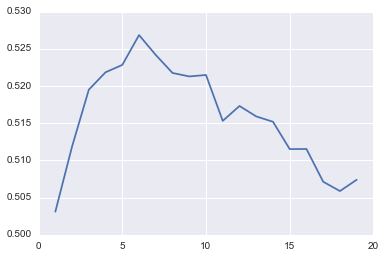

In [153]:
# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [21]:
# Get the best estimator
best = grid.best_estimator_
print best
print cross_val_score(best, features, target, cv=10, scoring='roc_auc').mean()
print cross_val_score(logreg, features, target, cv=10, scoring='roc_auc').mean()

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=1, splitter='best')
0.520864857743
0.523766214653


In [139]:
# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
criterion_range = ['gini', 'entropy']
max_feaure_range = range(1,10)
param_grid = dict(max_depth=depth_range, criterion=criterion_range, max_features=max_feaure_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(features, target)

# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# Get the best estimator
best = grid.best_estimator_
#best_features = grid.best_features_
print best
#print best_features
print cross_val_score(best, features, target, cv=10, scoring='accuracy').mean()
print cross_val_score(logreg, features, target, cv=10, scoring='accuracy').mean()

#use roc_auc for finding best model fit
#want to crossvalidate accuracy on best performer

ValueError: max_features must be in (0, n_features]

###Support Vector Machine (SVM)

In [22]:
from sklearn import svm, linear_model, datasets
clf = svm.SVC()
clf.fit(features,target)
print cross_val_score(clf, features, target, cv=10, scoring='roc_auc').mean()
print cross_val_score(clf, features, target, cv=10, scoring='accuracy').mean()

0.509782107763
0.542342924866


In [141]:
'''
Intuitively, the gamma parameter defines how far the influence of a 
single training example reaches, with low values meaning ‘far’ and 
high values meaning ‘close’. 

small gamma: the model is constrained, can under-fit!
big gamma: Tries to capture the shape too well: can over-fit!

small C: makes the decision surface smooth and simple, can under-fit!
big C: selects more support vectors: can over-fit!
'''
C_range = 10.**np.arange(-2, 3)
gamma_range = 10.**np.arange(-5, 2)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(features, target)

print grid.best_score_
print grid.best_params_
print grid.best_estimator_

KeyboardInterrupt: 

### Logistic Regression

In [23]:
logistic = linear_model.LogisticRegression()
print cross_val_score(logistic, features, target, cv=5, scoring='roc_auc').mean()
print cross_val_score(logistic, features, target, cv=5, scoring='accuracy').mean()

0.524253664669
0.54148163137


In [24]:
C_range = 10.**np.arange(-2, 3)
gamma_range = 10.**np.arange(-5, 2)
param_grid = dict(C=C_range)
grid = GridSearchCV(logistic, param_grid, cv=10, scoring='accuracy')
grid.fit(features, target)

print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.54284159942
{'C': 1.0}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
